In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
sns.set(style="ticks")
%matplotlib inline

In [89]:
df = pd.read_csv("cs109a_final_data_Milestone3.csv")
# we get rid of any NaN and re-adjust the dataframe's index
df = df[np.isnan(df["followers"]).apply(lambda x : not x)]
df = df.set_index(np.arange(0,len(df), 1))

Before we started looking at our predictors, we wanted to make sure that our dependent variable looked approximately normally distributed. As can be observed below, the original histogram looked quite poor in that respect, and presented a severe right-skew. We therefore used a log-transformation, which yielded a much more normally distributed variable. Another rationale behind this transformation is that the number of followers is affected by the visibility of the playlist on Spotify, which in turn, is affected by the popularity of the playlist. Therefore this circle might lead the number of followers to increase somewhat exponentially rather than linearly, which is why a logarithmic transformation makes sense here. For the rest of this analysis, we will always be looking at log(followers +1), our dependent variable throughout the analysis.

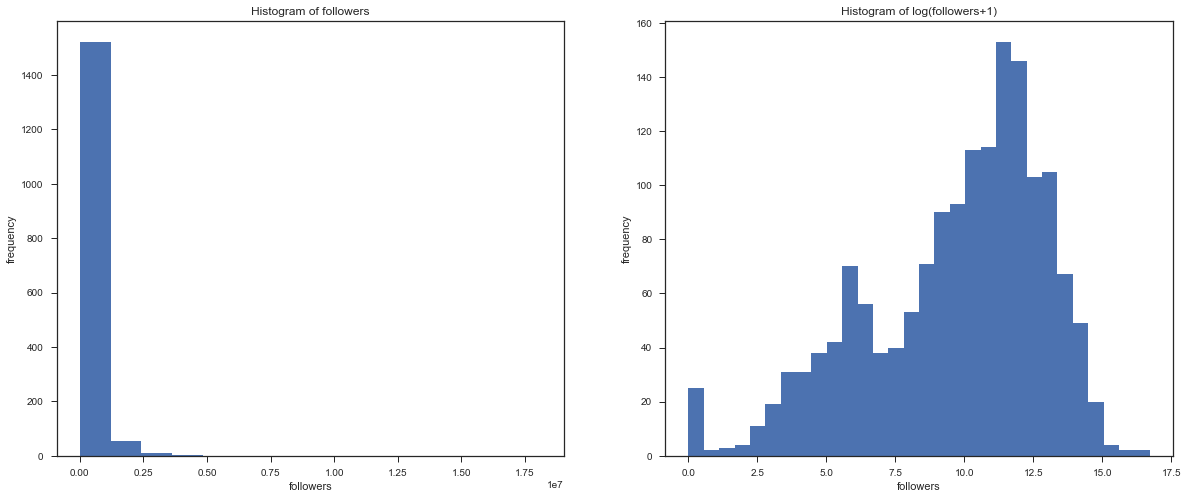

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# we display the histogram of our original 'followers' variable, and its transformation.
ax[0].hist(df['followers'], bins = 15)
ax[0].set_title('Histogram of followers')
ax[0].set_xlabel('followers')
ax[0].set_ylabel('frequency')
ax[1].hist(np.log(df['followers']+1), bins = 30)
ax[1].set_title('Histogram of log(followers+1)')
ax[1].set_xlabel('followers')
ax[1].set_ylabel('frequency')

We then wanted to make sure that our predictors were not too extremely correlated, in which case we would need to potentially get rid of some of the more correlated ones. We created the following heat map below to show the correlation between our numerical predictors. Nothing too extreme or out of the ordinary jumped out to us, so we did not alter any of our data at that point.

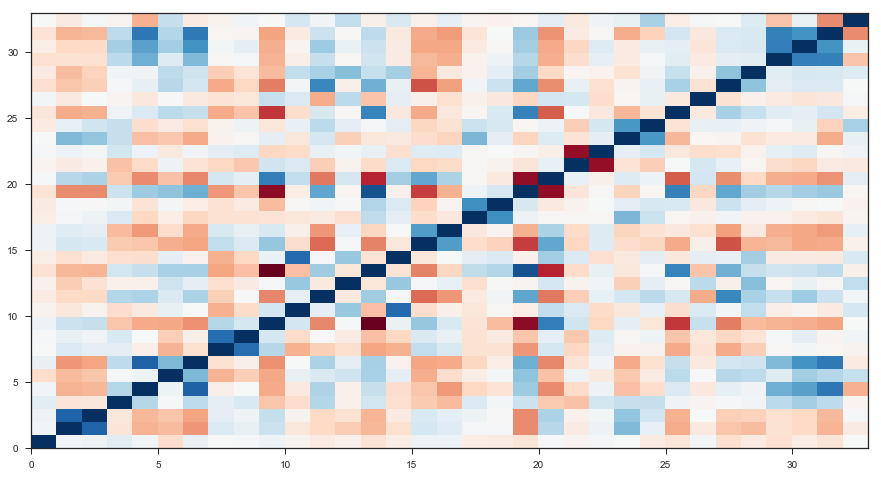

In [109]:
corr = df.drop({'Unnamed: 0', 'id', 'name', 'followers', 'collab', 'user','genre1', 'genre2', 'genre3'}, 1)
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
plt.pcolor(np.corrcoef(corr.transpose()), cmap='RdBu')

We now started looking at how our dependent variable correlated with some of the variables we expected to have a strong impact on the playlist's popularity. For example, we thought playlists featuring popular songs or popular artists would be likely to attract more followers. The following graphs indeed display a significant positive correlation. The mean_popularity graph is interesting because it also reflects the slight bimodality we observe in the histogram, with two different clusters, both positively correlated with mean_popularity.

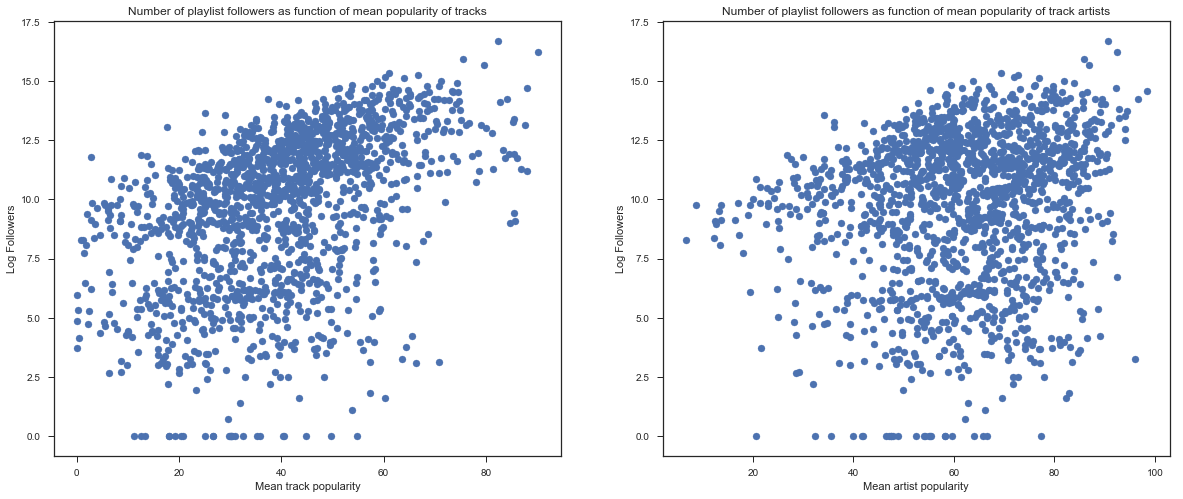

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# scatterplot of mean_popularity and the transformed followers variable
ax[0].scatter(df['mean_popularity'], np.log(df['followers']+1))
ax[0].set_title('Number of playlist followers as function of mean popularity of tracks')
ax[0].set_xlabel('Mean track popularity')
ax[0].set_ylabel('Log Followers')
# scatterplot of mean_artistpopularity and the transformed followers variable
ax[1].scatter(df['mean_artistpopularity'], np.log(df['followers']+1))
ax[1].set_title('Number of playlist followers as function of mean popularity of track artists')
ax[1].set_xlabel('Mean artist popularity')
ax[1].set_ylabel('Log Followers')

In an attempt to extract more information from our individual tracks' information, we also looked at the standard deviation of certain features. Namely, we look here at the standard deviation of tracks' popularity, which seems to display a slight downward parabola. We can imagine that there might be an optimal standard deviation that represents a good mix of music people are familiar with and music that is slightly more obscure, for a good balance of discovery and familiarity. Anything above that or below that could be either too generic or too hard to find in the first place. We also looked at the standard deviation of valence, although the interpretation turned out to be a little more difficult. We can still observe a slight downward trend, showing people might appreciate a playlist that is consistent in energy level.

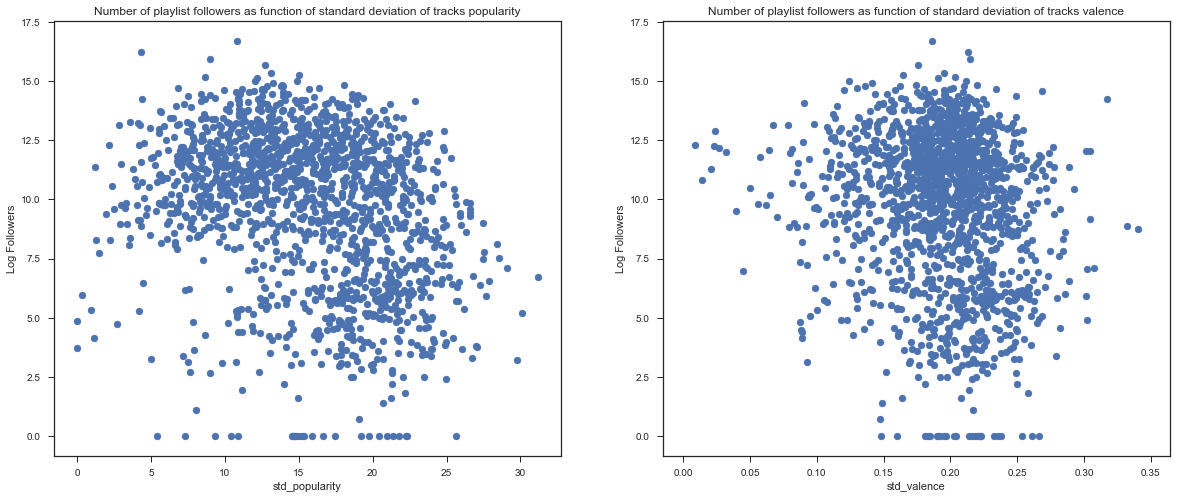

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# scatterplot of std_popularity and the transformed followers variable
ax[0].scatter(df['std_popularity'], np.log(df['followers']+1))
ax[0].set_title('Number of playlist followers as function of standard deviation of tracks popularity')
ax[0].set_xlabel('std_popularity')
ax[0].set_ylabel('Log Followers')
# scatterplot of std_valence and the transformed followers variable
ax[1].scatter(df['std_valence'], np.log(df['followers']+1))
ax[1].set_title('Number of playlist followers as function of standard deviation of tracks valence')
ax[1].set_xlabel('std_valence')
ax[1].set_ylabel('Log Followers')

We then extracted genre features for each song, and then extracted the three that recurred most often for each playlist in the variables genre1, genre2 and genre3. The following bar plot shows the 30 ones that came back most often.

<function matplotlib.pyplot.show>

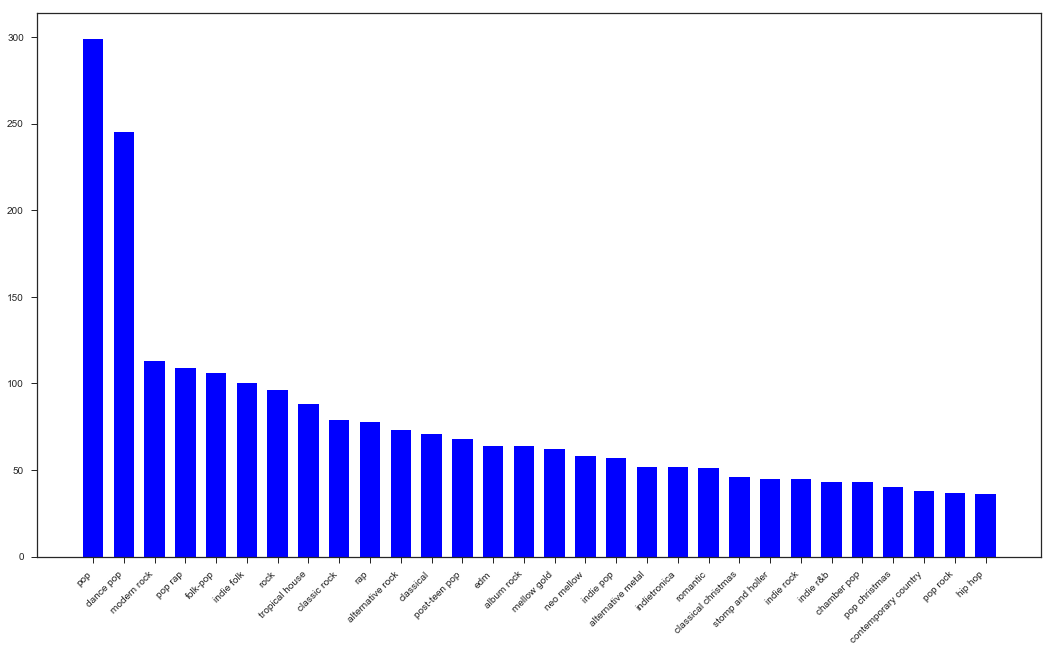

In [126]:
# count the genres that come back most often within our top 3 for each playlist
cnt=Counter(list(df["genre1"])+list(df["genre2"])+list(df["genre3"]))
plt.figure(figsize=(18,10))
# look at most common ones, store their names and number of occurences in the following variables
names = list(zip(*cnt.most_common()))[0][:30]
freq = list(zip(*cnt.most_common()))[1][:30]
width = 1/1.5
# bar plot of the 30 most frequent genres
plt.bar(range(len(freq)), freq, width, color="blue")
plt.xticks(range(0,30), names, ha='right', rotation=45)
plt.show

Overall, we observed a grand total of 500 genres, which is way too many to analyze individually, both because some of them will only be common to a few playlists, and because we would not want this many dummy variables in our model. We also observed genres such as 'alternative rock', 'album rock', 'indie rock' which could clearly be analyzed together. In an effort to do that, we tried to list some of the genres that recur quite often in some shape or form, and to create a non-extensive list of dummies if the playlists' top 3 genres included that genre in some shape or form. 

In [136]:
# we create the list of genres we wish to look at
genres = ['rock', 'jazz', 'pop', 'rap', 'indie', 'country', 'house', 'tropical', 'christmas', 'soul', 'folk', 'classical']
for genre in genres:
    # for each genre within that list, we create a corresponding column in our dataframe
    df[genre] = np.zeros(len(df))
    for i in range(len(df)):
        # for each observation, if the said genre appears anywhere within the top 3 most popular genres, we make the
        # corresponding dummy variable equal to 1 instead of 0.
        if genre in df['genre1'][i] or genre in df['genre2'][i] or genre in df['genre3'][i]:
            df.loc[i,genre] = 1

Now that we've extracted the genre feature, we can create a boxplot to visualize how the playlists' popularity varies depending on what genre category it falls into. We observe that a few smaller genres (house, tropical, and to some lesser extent rap and soul) have a very high average number of followers, compared to the ones like pop and rock that span a much larger spectrum of popularity. There is enough variability in these genres for us to hope they might be useful in predicting playlist popularity

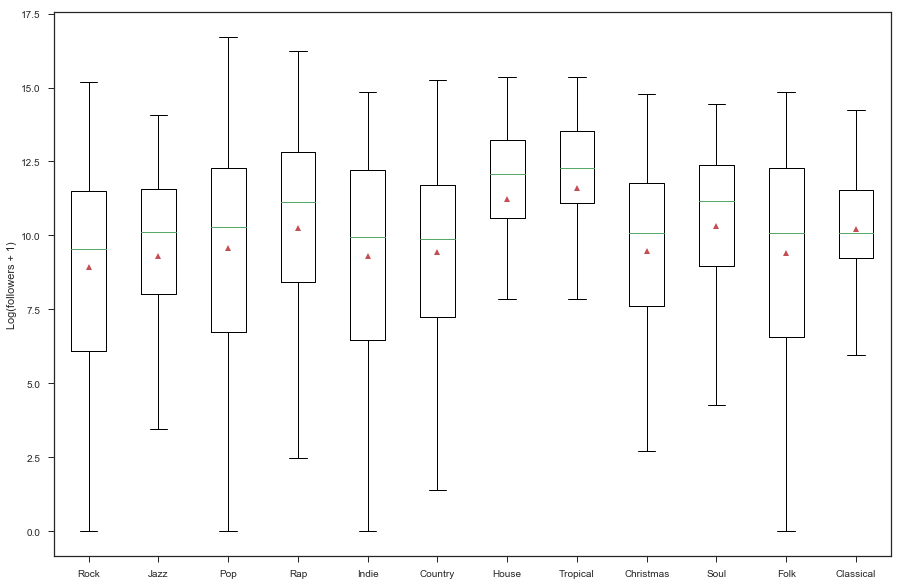

In [141]:
plt.figure(figsize=(15,10))
# using the new genre features, we create a boxplot
plt.boxplot([np.log(df["followers"][df['rock']==1].values+1),
             np.log(df["followers"][df['jazz']==1].values+1),
             np.log(df["followers"][df['pop']==1].values+1),
             np.log(df["followers"][df['rap']==1].values+1),
             np.log(df["followers"][df['indie']==1].values+1),
             np.log(df["followers"][df['country']==1].values+1),
             np.log(df["followers"][df['house']==1].values+1),
             np.log(df["followers"][df['tropical']==1].values+1),
             np.log(df["followers"][df['christmas']==1].values+1),
             np.log(df["followers"][df['soul']==1].values+1),
             np.log(df["followers"][df['folk']==1].values+1),
             np.log(df["followers"][df['classical']==1].values+1)], showmeans=True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['Rock', "Jazz","Pop","Rap","Indie","Country","House","Tropical","Christmas",
                                         "Soul","Folk","Classical"])
plt.ylabel("Log(followers + 1)")